<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#autophototroph-phenomenological-model-(garcia2018role)" data-toc-modified-id="autophototroph-phenomenological-model-(garcia2018role)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>autophototroph phenomenological model (garcia2018role)</a></span></li><li><span><a href="#phenomenological-model-trial" data-toc-modified-id="phenomenological-model-trial-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>phenomenological model trial</a></span></li></ul></div>

In [1]:
using RCall, PyCall, Plots, ProgressMeter, DataFrames
mt = pyimport("math")
sc = pyimport("scipy")
cst = pyimport("scipy.constants")
itg = pyimport("scipy.integrate")
R"cbp<-c('#000000', '#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#e79f00', '#9ad0f3', '#F0E442', '#999999', '#cccccc', '#6633ff', '#00FFCC', '#0066cc')"
println()

# autophototroph phenomenological model (garcia2018role)

In [2]:
function expFunc(k, A0, T0, E1, T1)
    A = A0 *mt.exp(E1/k*(1/T1-1/T0))
    return (A)
end

expFunc (generic function with 1 method)

In [3]:
function metabolic(k, B0, T0, Ea, T, Ed, Th)
    # give general inputs for parameters (Pg, RL, RD)
    B = expFunc(k, B0, T0, -Ea, T)/(1 + expFunc(k, B0, T, Ed, Th)/B0)
    return (B)
end

metabolic (generic function with 1 method)

In [4]:
function autotroph(pops, t, S, ks, T0C, TC, eps, Pgs, RLs, RDs)
    ## hourly model
    ## input data in unit "day" and "degree Celcius"
    ## eps: [e0, Ee]
    ## Pgs: [P0, Ea, Ed, Th]
    ## RLs: [RL0, Ea, Ed, Th]
    ## RDs: [RD0, Ea, Ed, Th]
    
    N = pops[:1]
    T0 = T0C + 273.15 # reference temperature in Kelvin
    T = TC + 273.15 # test temperature in Kelvin
    k = cst.k * 6.24150934 * 10^18 ## J/K -> eV/K Boltzmann constant
    
    Vn = S/(S+ks)
    ep = expFunc(k, eps[:1], T0, -eps[:2], T) # efficiency
    Pg = metabolic(k, Pgs[:1]*24, T0, Pgs[:2], T, Pgs[:3], Pgs[:4] + 273.15) # max gross photosynthesis rate
    RL = metabolic(k, RLs[:1]*24, T0, RLs[:2], T, RLs[:3], RLs[:4] + 273.15) # daytime respiration rate
    RD = metabolic(k, RDs[:1]*24, T0, RDs[:2], T, RDs[:3], RDs[:4] + 273.15) # night-time respiration rate
    Fc = Pg-RL-RD # net carbon flux
    
    gRt = N*Vn*ep*Fc # gRt = N* rpu: rate per unit
    cue = 1-RL/Pg # cue: carbon use efficiency
    return ([gRt, cue])
end

autotroph (generic function with 1 method)

# phenomenological model trial

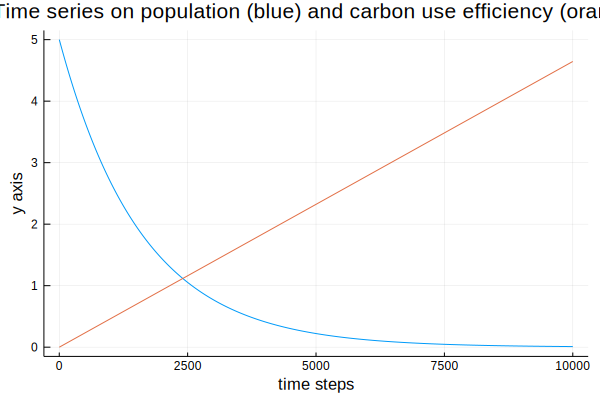

In [5]:
t = sc.linspace(0, 24, 10000) # time series (hours)
pops = sc.array([5,0]) # initial population p, q

## parameters
S = .1 # random (rnd)
ks = .291
T0C = 20 # rnd
TC = 30 # random
eps = sc.array([.068,.636])
Pgs = sc.array([.31,.64,.78,35]) # [rnd, paper, rnd, rnd]
RLs = sc.array([.25,.64,.78,35]) # [rnd, paper, rnd, rnd]
RDs = sc.array([.25,.64,.78,35]) # [rnd, paper, rnd, rnd]

pops, infodict = itg.odeint(autotroph, pops, t, full_output=true, args=(S, ks, T0C, TC, eps, Pgs, RLs, RDs))
plot(pops, xlabel="time steps", ylabel="y axis", title="Time series on population (blue) and carbon use efficiency (orange)", label="")